In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

### Read the data frame

In [2]:
df = pd.read_pickle('Results/initial_area_curves.pkl')

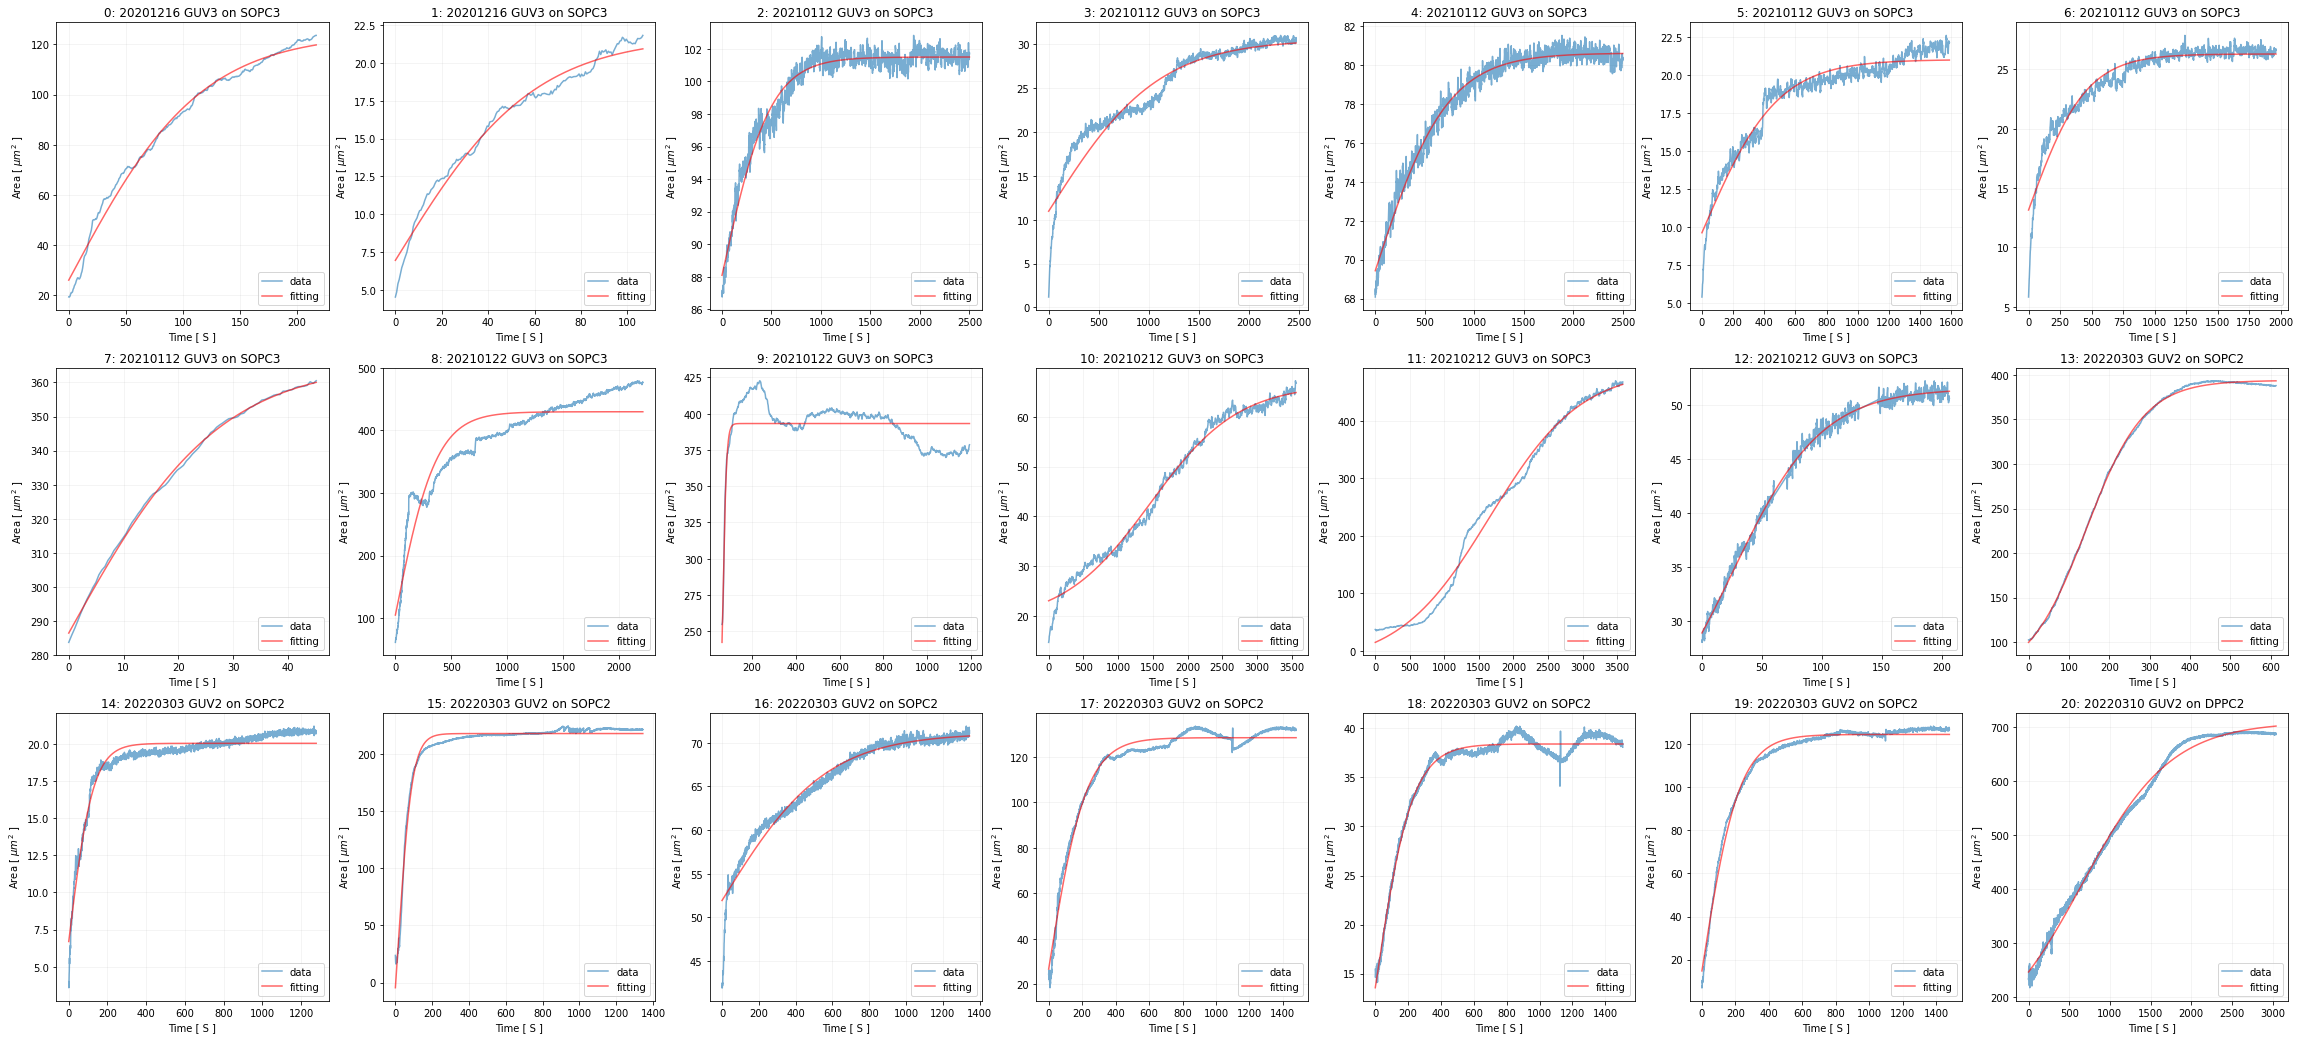

In [3]:
# Define a general hyperbolic tangent function
def area_tanh(t, a, b, c, d):
    return a*np.tanh(b*(t-c))+d

parameters = []
for i in range(21):
    t, A = df['Time'][i], df['Area'][i]
    popt, pcov = curve_fit(area_tanh, t, A, p0=(1, 0.01, 0, 0), bounds=([0, 0.0001, 0, -np.max(A)], [np.max(A), 1, t[-1], np.max(A)]))
    parameters.append(popt)
    
    # Define the figure size only once
    if i==0: plt.figure(figsize=(40, 18))
    
    plt.subplot(3, 7, i+1)
    plt.plot(t, A, label='data', alpha = 0.6)                                  # data
    plt.plot(t, area_tanh(t, *popt), label='fitting', alpha = 0.6, color= 'r') # fitting
    plt.title(f'{i}: {df["Date"][i]} {df["Discription"][i]}')
    plt.xlabel('Time [ S ]')
    plt.ylabel('Area [ $\mu m^2$ ]')
    plt.grid(color = 'gray', alpha = 0.1)
    plt.legend(loc='lower right')
    
plt.savefig('Results/initial_area_curves_1')

In [4]:
for i, parameter in enumerate(parameters):
    print(i, ' --> {:.1f} tanh[{:.1e} (t - {:.1e}) ] + {:.1f}'.format(*parameter))

0  --> 98.5 tanh[8.6e-03 (t - 2.3e-14) ] + 25.9
1  --> 14.8 tanh[1.7e-02 (t - 6.0e-13) ] + 7.0
2  --> 13.4 tanh[2.1e-03 (t - 7.5e-10) ] + 88.1
3  --> 19.6 tanh[9.2e-04 (t - 1.1e-14) ] + 11.0
4  --> 11.2 tanh[1.4e-03 (t - 6.9e-12) ] + 69.4
5  --> 11.4 tanh[2.1e-03 (t - 6.7e-13) ] + 9.6
6  --> 13.1 tanh[2.2e-03 (t - 2.3e-20) ] + 13.1
7  --> 79.3 tanh[3.6e-02 (t - 2.8e-12) ] + 286.5
8  --> 324.6 tanh[2.7e-03 (t - 6.6e-43) ] + 105.1
9  --> 118.9 tanh[6.1e-02 (t - 6.7e+01) ] + 274.3
10  --> 24.0 tanh[7.9e-04 (t - 1.5e+03) ] + 42.6
11  --> 257.2 tanh[7.6e-04 (t - 1.7e+03) ] + 233.2
12  --> 17.0 tanh[1.3e-02 (t - 2.6e+01) ] + 34.5
13  --> 167.2 tanh[7.0e-03 (t - 1.4e+02) ] + 226.6
14  --> 13.4 tanh[8.0e-03 (t - 1.2e-14) ] + 6.7
15  --> 186.5 tanh[1.3e-02 (t - 1.5e+01) ] + 31.5
16  --> 19.2 tanh[1.8e-03 (t - 4.9e-13) ] + 51.9
17  --> 101.9 tanh[4.5e-03 (t - 2.6e-13) ] + 26.6
18  --> 24.9 tanh[4.5e-03 (t - 4.9e-13) ] + 13.6
19  --> 109.9 tanh[4.5e-03 (t - 1.9e-14) ] + 14.7
20  --> 302.1 tanh[9.